In [1]:
from utils import *

### Data Loading

In [57]:
class CustomDataLoader:
    
    def __init__(self, test_size=0.05):
        
        self.MAX_NEIGHBOURS_SIZE = 10
        self.MAX_FEATS = 26
        self.fillingValueForPadding = -1
        self.decade = 34
        self.maxDecade = 34
        self.windowSize = 5
        self.stride = 1
        self.yearsCount = 4
        self.fillingTensor = -torch.ones([self.decade-self.windowSize+1, self.MAX_NEIGHBOURS_SIZE, self.MAX_FEATS])
        self.data = pd.read_pickle("data/df_gesamt_prepocessed_reordered.pkl")
        self.listOfT = [f'T{i+1}' for i in range(self.decade)]
        
        # to keep indices for train and vals sets
        self.data.reset_index(drop=True, inplace=True)
        self.data.drop(columns=["PLZ", "Ort"], inplace=True)
        
        # split Qid into train and val
        self.Qid_train, self.Qid_val = train_test_split(self.data["Qid"].unique(), 
                                              test_size=test_size,
                                              random_state=23)
        
        self.data.Laenge = self.normalize_longitude(self.data.Laenge.values)
        self.data.Breite = self.normalize_latitude(self.data.Breite.values)

        # normalizing columns without last year data
        self.normalize_without_target_year(self.data, "PPSVACWert")
        
        
        # splitting data to years
        self.data_2018 = self.data[self.data["GJ"] == 2018].copy()
        self.data_2019 = self.data[self.data["GJ"] == 2019].copy()
        self.data_2022 = self.data[self.data["GJ"] == 2022].copy()
        self.data_2023 = self.data[self.data["GJ"] == 2023].copy()
        
        # dropping unnecessary columns
        self.data.drop(columns=["GJ"], inplace=True)
        self.data_2018.drop(columns=["GJ"], inplace=True)
        self.data_2019.drop(columns=["GJ"], inplace=True)
        self.data_2022.drop(columns=["GJ"], inplace=True)
        self.data_2023.drop(columns=["GJ"], inplace=True)
        
        
        self.distances_2018 = pd.read_csv("data/distances/distances_2018.csv")
        self.distances_2019 = pd.read_csv("data/distances/distances_2019.csv")
        self.distances_2022 = pd.read_csv("data/distances/distances_2022.csv")
        self.distances_2023 = pd.read_csv("data/distances/distances_2023.csv")

    def normalize_longitude(self, longitude):
        min_lon = -180.0
        max_lon = 180.0
        normalized_lon = (longitude - min_lon) / (max_lon - min_lon)
        return normalized_lon

    def normalize_latitude(self, latitude):
        min_lat = -90.0
        max_lat = 90.0
        normalized_lat = (latitude - min_lat) / (max_lat - min_lat)
        return normalized_lat
    
    def normalize_without_target_year(self, data, col):
        
        def mean_std_norm(x):
            return (x - x.mean()) / x.std()
        
        index = data.index
        data.loc[index, col] = mean_std_norm(data.loc[index, col])

    def loader(self):       
        train_dataReturn_X, val_dataReturn_X = [], []
        train_dataReturn_Y, val_dataReturn_Y = [], []
        
        # Define a function to process a single Qid
        def process_qid(qid):
            qid2_2018 = self.takeTopNeighbours(self.distances_2018, qid)
            qid2_2019 = self.takeTopNeighbours(self.distances_2019, qid)
            qid2_2022 = self.takeTopNeighbours(self.distances_2022, qid)
            
            if qid2_2018.shape[0]:
                curr_2018_X = self.takeByQid(self.data_2018, self.distances_2018, qid2_2018)
            else:
                curr_2018_X = self.fillingTensor
                
            if qid2_2019.shape[0]:
                curr_2019_X = self.takeByQid(self.data_2019, self.distances_2019, qid2_2019)
            else:
                curr_2019_X = self.fillingTensor
                
            if qid2_2022.shape[0]:
                curr_2022_X = self.takeByQid(self.data_2022, self.distances_2022, qid2_2022)
            else:
                curr_2022_X = self.fillingTensor
                        
            curr_2023_X = self.takeByQidLastYear(self.data_2023, qid)
            currData_X = torch.cat([curr_2018_X, curr_2019_X, curr_2022_X, curr_2023_X], axis=0)
            currData_Y = self.takeTargetByQid(self.data_2023, qid)
            return currData_X, currData_Y

        for qid in tqdm(self.Qid_train):
            currData_X, currData_Y = process_qid(qid)
            train_dataReturn_X.append(currData_X)
            train_dataReturn_Y.append(currData_Y)

        for qid in tqdm(self.Qid_val):
            currData_X, currData_Y = process_qid(qid)
            val_dataReturn_X.append(currData_X)
            val_dataReturn_Y.append(currData_Y)
            
        X_train = torch.squeeze(torch.stack(train_dataReturn_X))
        y_train = torch.stack(train_dataReturn_Y)
        
        X_val = torch.squeeze(torch.stack(val_dataReturn_X))
        y_val = torch.stack(val_dataReturn_Y)
        
        return X_train, X_val, y_train, y_val

    def takeByQid(self, dataPart, dist, qids): 
        currData_X = dataPart[dataPart.Qid.isin(qids)].copy()

        drop_columns = ["Qid"]
        if self.decade != self.maxDecade:
            drop_columns += [f"T{i}" for i in range(self.decade + 1, self.maxDecade+1)]

        currData_X.drop(columns=drop_columns, inplace=True)
        if currData_X.shape[0]:
            const = currData_X.loc[:, :'PPSVACWert'].values
            window_starts = np.arange(1, (self.decade - (self.windowSize - 1) - 1)//self.stride + 2, self.stride)
            num_windows = len(window_starts)
            window_ends = window_starts + self.windowSize

            retutnData = []
            for t in window_starts:
                curr_x = np.concatenate([
                    const,
                    currData_X.loc[:, f"T{t}":f"T{t+self.windowSize-1}"].values
                ], axis=1)

                curr_tensor = self.pad_to_size(torch.tensor(curr_x.astype(float)))
                retutnData.append(curr_tensor)
            
            return torch.stack(retutnData)[..., 0]
        else: 
            return self.fillingTensor


    def takeByQidLastYear(self, dataPart, qid):
        currData = dataPart[dataPart.Qid == qid].copy()
        if currData.shape[0]:
            price = currData.Preis.values
            price_array = np.full(currData[self.listOfT].shape, price)
            currData[self.listOfT] = -1
            currData["PPSVACWert"] = -1
            currData.drop(columns=["Qid"], inplace=True)
            currData.drop(columns=[f"T{i}" for i in range(self.windowSize+1, self.maxDecade+1)], inplace=True)
            return self.pad_to_size(torch.tensor(currData.astype(float).values))[..., 0][None]
        else: 
            return-torch.ones([1, self.MAX_NEIGHBOURS_SIZE, self.MAX_FEATS])
        

    def takeTargetByQid(self, dataPart, qid):
        targetRows = dataPart[dataPart.Qid == qid].copy()
        if targetRows.shape[0]:
            T = targetRows.loc[:, "T1":"T22"].copy() 
            T[T == -1] = 0
            meanOf_T = T.mean().mean()
            return torch.tensor([meanOf_T])

        return torch.tensor([0.])
    
    
    def takeTopNeighbours(self, df, qid, top=10):
        current_data = df[df.Qid1 == qid]
        sorted_data = current_data.sort_values(by='distance')

        self_pair = sorted_data[sorted_data.Qid2 == qid]
        
        if not self_pair.empty:
            sorted_data = sorted_data[sorted_data.Qid2 != qid]
            sorted_data = pd.concat([self_pair, sorted_data], ignore_index=True)

        return sorted_data.iloc[:top].Qid2.values

        
    def pad_to_size(self, tensor):
        # Check if the tensor is 2D
        if len(tensor.shape) != 2:
            raise ValueError("Input tensor should be 2D")

        current_x, current_y = tensor.shape
        pad_left = 0
        pad_right = 0
        pad_top = 0
        pad_bottom = max(0, self.MAX_NEIGHBOURS_SIZE - current_x)

        return torch.nn.functional.pad(tensor, (pad_left, pad_right, pad_top, pad_bottom), "constant", self.fillingValueForPadding)[..., None]
    
    def drop_less_years(self, data):
        mask = (data.groupby(["Qid"])[["GJ"]].transform('count') < self.yearsCount).values
        data.drop(index=data[mask].index, inplace=True)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path_x, path_y, p=0.1):
        
        self.data_x = torch.load(path_x)
        self.data_y = torch.load(path_y)
        self.p = p
    
    def __getitem__(self, index):
        
        tmp = self.data_x[index].clone()
        
        if torch.rand(1) < self.p:
            return self._transform(tmp, self.data_y[index].clone())
        else:
            return tmp, self.data_y[index]
    
    def _transform(self, data_x, data_y, k_factor=2):
        
        maxPrice = max(data_x[[0, 31, 61, -1], 0, 15])
            
        data_x[-1, 0, 15] = k_factor * maxPrice
        data_y *= 0
        
        return data_x, data_y        
    
    def __len__(self):
        return len(self.data_x)
    
class LSTMModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        X = X.reshape(*X.shape[:2],-1)
        out, _ = self.lstm(X)
        out = self.fc(out[:, -1])
        pos_out = torch.sigmoid(out)
        
        return pos_out

In [58]:
dl = CustomDataLoader()

In [59]:
X_train, X_val, y_train, y_val = dl.loader()

100%|███████████████████████████████████████| 7908/7908 [03:15<00:00, 40.48it/s]


In [62]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([150236, 91, 10, 26]),
 torch.Size([7908, 91, 10, 26]),
 torch.Size([150236, 1]),
 torch.Size([7908, 1]))

In [63]:
torch.save(X_train, 'data/saved_train_val_data/X_train_normal_10_08.pt')
torch.save(y_train, 'data/saved_train_val_data/y_train_normal_10_08.pt')
torch.save(X_val, 'data/saved_train_val_data/X_val_normal_10_08.pt')
torch.save(y_val, 'data/saved_train_val_data/y_val_normal_10_08.pt')

In [64]:
train_dataset = CustomDataset("./data/saved_train_val_data/X_train_normal_10_08.pt", 
                              "./data/saved_train_val_data/y_train_normal_10_08.pt")

val_dataset = CustomDataset("./data/saved_train_val_data/X_val_normal_10_08.pt", 
                            "./data/saved_train_val_data/y_val_normal_10_08.pt")

In [65]:
# Defining hyperparams
BATCH_SIZE = 64
NUM_SEQUENCE = 91
NUM_FEATURES = 10*26
NUM_LAYERS = 3
OUTPUT_SIZE = 1
HIDDEN_SIZE = 64
INPUT_SIZE = NUM_FEATURES

# Create a DataLoader to handle batching
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Model  |  Loss |  Optimizer Defining

In [66]:
# Creating model
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
model.to(DEVICE)
# Defining Loss function
criterion = nn.MSELoss()  
# Defining optimizer
lr = 0.0003
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 

### Training

In [67]:
num_epochs = 50
history = []

iters = len(train_dataloader)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr, max_lr=0.001, cycle_momentum=False)

val_min_loss = None

model_name = input("Input proper model name:\t")

for epoch in range(num_epochs):
    train_running_loss = 0.0
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):

        # Every data instance is an input + label pair
        X_train1, y_train1 = batch[0].to(torch.float32).to(DEVICE), batch[1].to(torch.float32).to(DEVICE)

        # Make predictions for this batch
        outputs = model(X_train1)

        # Compute the loss and its gradients
        loss = criterion(outputs, y_train1)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        scheduler.step()
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Gather data and report
        train_running_loss += loss.item()
    
    model.eval()
    val_running_loss = 0.
    
    with torch.no_grad():
        for i, batch in enumerate(tqdm(val_dataloader, position=0, leave=True)):

            # Every data instance is an input + label pair
            X_val1, y_val1 = batch[0].to(torch.float32).to(DEVICE), batch[1].to(torch.float32).to(DEVICE)

            # Make predictions for this batch
            outputs = model(X_val1)
            # Compute the loss and its gradients
            loss = criterion(outputs, y_val1)
            
            # Gather data and report
            val_running_loss += loss.item()

    mean_train_loss = train_running_loss/len(train_dataloader)
    mean_val_loss = val_running_loss/len(val_dataloader)
    
    if val_min_loss is None:
        val_min_loss = mean_val_loss
    else:
        if mean_val_loss < val_min_loss:
            val_min_loss = mean_val_loss
            torch.save(model.state_dict(), f'./models/{model_name}.pth')
    
    history.append([mean_train_loss, mean_val_loss])
    
    print(f"Epoch [{epoch+1}/{num_epochs}]\nTrain Loss: {round(mean_train_loss, 4)}\nVal Loss: {round(mean_val_loss, 4)}")

Input proper model name:	positive_norm


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 155.44it/s]


Epoch [1/50]
Train Loss: 0.0376
Val Loss: 0.0308


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 161.03it/s]


Epoch [2/50]
Train Loss: 0.026
Val Loss: 0.0245


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 158.11it/s]


Epoch [3/50]
Train Loss: 0.025
Val Loss: 0.0239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 153.47it/s]


Epoch [4/50]
Train Loss: 0.0236
Val Loss: 0.0239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 157.79it/s]


Epoch [5/50]
Train Loss: 0.0237
Val Loss: 0.0226


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 140.55it/s]


Epoch [6/50]
Train Loss: 0.023
Val Loss: 0.0238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 156.01it/s]


Epoch [7/50]
Train Loss: 0.0228
Val Loss: 0.0223


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 158.79it/s]


Epoch [8/50]
Train Loss: 0.0228
Val Loss: 0.0235


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 158.74it/s]


Epoch [9/50]
Train Loss: 0.022
Val Loss: 0.0224


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 149.62it/s]


Epoch [10/50]
Train Loss: 0.0225
Val Loss: 0.0221


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 153.80it/s]


Epoch [11/50]
Train Loss: 0.0217
Val Loss: 0.0238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 152.81it/s]


Epoch [12/50]
Train Loss: 0.022
Val Loss: 0.0219


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 157.12it/s]


Epoch [13/50]
Train Loss: 0.0219
Val Loss: 0.0226


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 159.16it/s]


Epoch [14/50]
Train Loss: 0.0213
Val Loss: 0.0219


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 154.23it/s]


Epoch [15/50]
Train Loss: 0.0217
Val Loss: 0.0216


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 156.24it/s]


Epoch [16/50]
Train Loss: 0.0209
Val Loss: 0.0229


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 146.72it/s]


Epoch [17/50]
Train Loss: 0.0214
Val Loss: 0.0215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 153.25it/s]


Epoch [18/50]
Train Loss: 0.0212
Val Loss: 0.0218


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 147.26it/s]


Epoch [19/50]
Train Loss: 0.0209
Val Loss: 0.0209


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 148.51it/s]


Epoch [20/50]
Train Loss: 0.0211
Val Loss: 0.0211


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 147.96it/s]


Epoch [21/50]
Train Loss: 0.0205
Val Loss: 0.021


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 157.24it/s]


Epoch [22/50]
Train Loss: 0.0209
Val Loss: 0.0212


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 161.78it/s]


Epoch [23/50]
Train Loss: 0.0204
Val Loss: 0.0215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 156.58it/s]


Epoch [24/50]
Train Loss: 0.0205
Val Loss: 0.0207


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 153.94it/s]


Epoch [25/50]
Train Loss: 0.0205
Val Loss: 0.0217


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 154.38it/s]


Epoch [26/50]
Train Loss: 0.02
Val Loss: 0.021


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 150.94it/s]


Epoch [27/50]
Train Loss: 0.0204
Val Loss: 0.0211


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 157.92it/s]


Epoch [28/50]
Train Loss: 0.0198
Val Loss: 0.0209


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 150.10it/s]


Epoch [29/50]
Train Loss: 0.0201
Val Loss: 0.0208


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 139.89it/s]


Epoch [30/50]
Train Loss: 0.0198
Val Loss: 0.0212


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 156.81it/s]


Epoch [31/50]
Train Loss: 0.0197
Val Loss: 0.0208


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 155.67it/s]


Epoch [32/50]
Train Loss: 0.02
Val Loss: 0.0211


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 163.11it/s]


Epoch [33/50]
Train Loss: 0.0194
Val Loss: 0.0214


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 161.05it/s]


Epoch [34/50]
Train Loss: 0.0198
Val Loss: 0.0209


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 161.33it/s]


Epoch [35/50]
Train Loss: 0.0194
Val Loss: 0.0218


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 158.10it/s]


Epoch [36/50]
Train Loss: 0.0194
Val Loss: 0.0206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 161.19it/s]


Epoch [37/50]
Train Loss: 0.0196
Val Loss: 0.0215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 155.91it/s]


Epoch [38/50]
Train Loss: 0.0189
Val Loss: 0.0209


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 156.77it/s]


Epoch [39/50]
Train Loss: 0.0194
Val Loss: 0.0206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 149.44it/s]


Epoch [40/50]
Train Loss: 0.0189
Val Loss: 0.0212


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 154.12it/s]


Epoch [41/50]
Train Loss: 0.019
Val Loss: 0.021


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 161.47it/s]


Epoch [42/50]
Train Loss: 0.0189
Val Loss: 0.0209


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 161.97it/s]


Epoch [43/50]
Train Loss: 0.0186
Val Loss: 0.0204


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 158.69it/s]


Epoch [44/50]
Train Loss: 0.0189
Val Loss: 0.0208


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 153.50it/s]


Epoch [45/50]
Train Loss: 0.0182
Val Loss: 0.0219


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 160.83it/s]


Epoch [46/50]
Train Loss: 0.0189
Val Loss: 0.0207


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 162.12it/s]


Epoch [47/50]
Train Loss: 0.0185
Val Loss: 0.0212


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 159.63it/s]


Epoch [48/50]
Train Loss: 0.0182
Val Loss: 0.0218


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 162.61it/s]


Epoch [49/50]
Train Loss: 0.0185
Val Loss: 0.0206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 164.69it/s]

Epoch [50/50]
Train Loss: 0.0178
Val Loss: 0.0213


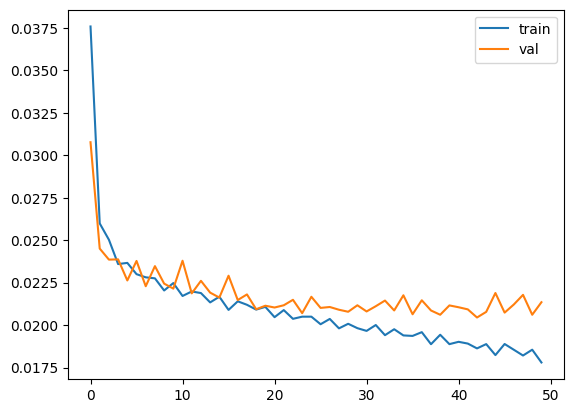

In [68]:
history = np.array(history)
plt.plot(history)
plt.legend(["train", "val"])
plt.show()

### Evaluation

In [69]:
X_val = torch.load("data/saved_train_val_data/X_val_normal_10_08.pt")
y_val = torch.load("data/saved_train_val_data/y_val_normal_10_08.pt")

In [70]:
model.eval()
preds = model(X_val.to(torch.float32).to(DEVICE)).detach().cpu().numpy()
ground_truth = (y_val).numpy()

### MAE on test data

In [71]:
print(np.abs(preds - ground_truth).mean().round(4))

0.1032


### KDE plot of ground truth and prediction

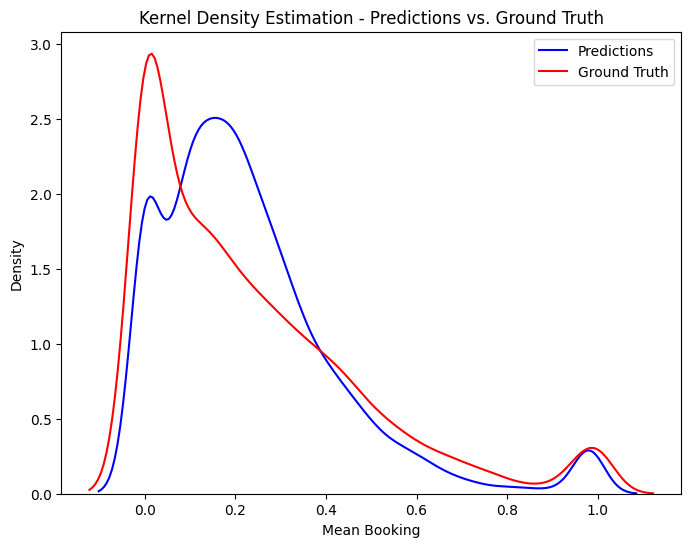

In [72]:
# Create KDE plots for predictions and ground truth
plt.figure(figsize=(8, 6))
sns.kdeplot(preds.squeeze(), label='Predictions', color='blue')
sns.kdeplot(ground_truth.squeeze(), label='Ground Truth', color='red')

# Set labels and title
plt.xlabel('Mean Booking')
plt.ylabel('Density')
plt.title('Kernel Density Estimation - Predictions vs. Ground Truth')
plt.legend()

# Show the plot
plt.show()

### Scatter plot

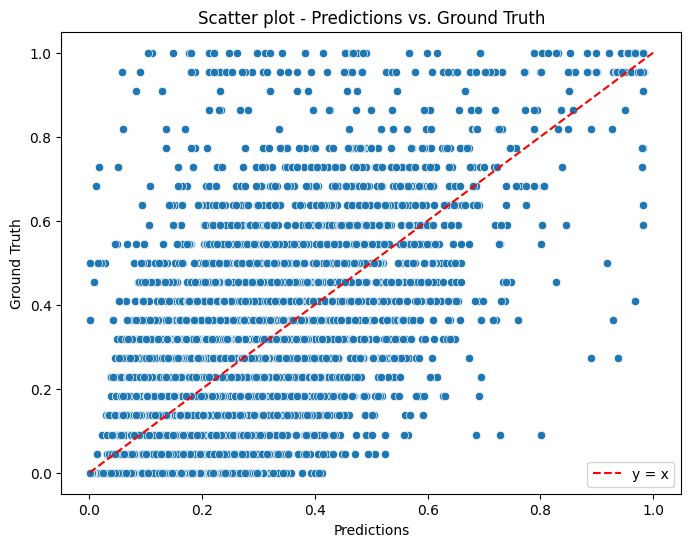

In [73]:
# Create a diagonal line for y = x
x_values = np.linspace(min(preds[..., 0].min(), ground_truth[..., 0].min()), max(preds[..., 0].max(), ground_truth[..., 0].max()), 100)
y_values = x_values

# Plot the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=preds[..., 0], y=ground_truth[..., 0])

# Plot the diagonal line
plt.plot(x_values, y_values, color='red', linestyle='dashed', label='y = x')

# Set labels and title
plt.xlabel('Predictions')
plt.ylabel('Ground Truth')
plt.title('Scatter plot - Predictions vs. Ground Truth')

# Show the plot
plt.legend()
plt.show()
